In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import re
from shapely.geometry import shape, mapping
import numpy as np
import seaborn as sns
import math

In [223]:
#Opening file and initial cleaning
df_original = pd.read_csv('FivePreventableCrimeCasesRecordedByNeighbourhoodPoliceCentreNPCAnnual.csv')
df_original['DataSeries'] = df_original['DataSeries'].str.strip()

years = df_original.columns[df_original.columns.str.isnumeric()]

df = df_original.replace('na',0).copy()

for year in years:
    df[year] = pd.to_numeric(df[year])



### General Trend

Overall decrease: 49.1%
2022 - 2023 Decrease: 6.23%
2019 - 2020 Decrease: 18.8%
Yearly reports (2021 - 2023): 1769
Overall average annual reports: 2187


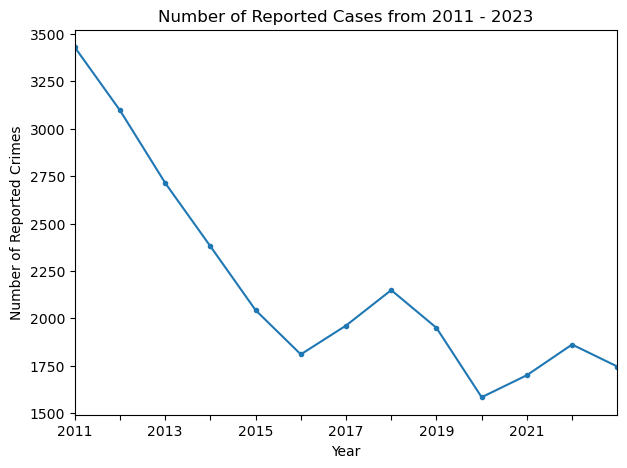

In [224]:
# Cleanup for general trend

df_totals = (df[df['DataSeries'].str.contains('Total')]).copy() # New dataframe

df_totals.loc['Total'] = df_totals.sum()

df_totals = df_totals.iloc[7] # Only get total
df_totals = df_totals.drop('DataSeries')

df_totals.sort_index()

# Calculations
# Overall decrease from 2011 - 2023 (%)
overall_decrease = ((df_totals['2011'] - df_totals['2023']) / df_totals['2011']) * 100
print(f'Overall decrease: {round(overall_decrease,2)}%')

# Decrease from 2022 - 2023
year23_decrease = ((df_totals['2022'] - df_totals['2023']) / df_totals['2022']) * 100
print(f'2022 - 2023 Decrease: {round(year23_decrease,2)}%')

# Decrease from 2019 - 2020
year20_decrease = ((df_totals['2019'] - df_totals['2020']) / df_totals['2019']) * 100
print(f'2019 - 2020 Decrease: {round(year20_decrease,1)}%')

# Average yearly reports from 2021 - 2023
average21to23 = round((sum([df_totals['2021'],df_totals['2022'],df_totals['2023']])) / 3)
print(f'Yearly reports (2021 - 2023): {average21to23}')

# Overall average yearly reports
average_overall = round((sum(df_totals)) / len(df_totals))
print(f'Overall average annual reports: {average_overall}')



# Plotting trend
df_totals[::-1].plot(
    kind='line', 
    title='Number of Reported Cases from 2011 - 2023',
    marker='.',
    figsize=(7, 5)
    )

plt.xlabel('Year')
plt.xticks(np.arange(0,12,1)) # Adding ticks
plt.xticks()
plt.xlim(0,12)
plt.ylabel('Number of Reported Crimes')

plt.savefig('LinePlot.png', transparent = True)

### Proportion of each type of crime

               DataSeries  2023  2022  2021  2020  2019  2018  2017  2016  \
0      Outrage Of Modesty  3016  3200  2930  2622  3173  3419  3090  2547   
1           Housebreaking   268   222   220   322   370   408   310   424   
2  Theft Of Motor Vehicle   134   202   170   120   169   228   284   330   
3                 Robbery    34    54    56    68   110   142   138   192   
4            Snatch Theft    40    46    24    36    70    96    98   126   

   2015  2014  2013  2012  2011  Total  
0  2570  2722  2626  2796  2758  37469  
1   500   620  1014  1090  1274   7042  
2   602   628   808  1168  1346   6189  
3   246   460   502   568   784   3354  
4   168   330   478   572   698   2782  


Text(0.5, 1.0, 'Types of Crimes Recorded (2011 - 2023)')

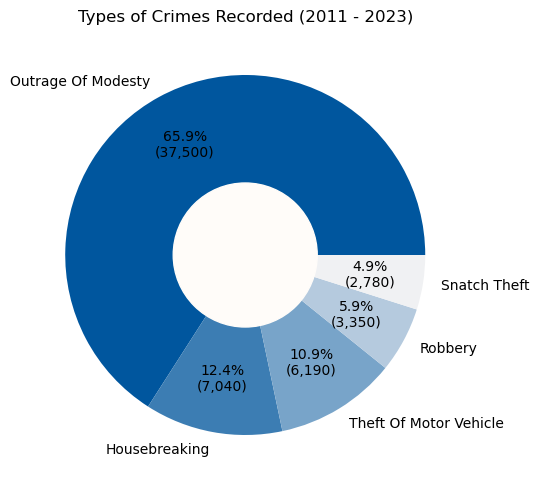

In [ ]:
def pie_count_label(pct): # Takes percentage as parameter (only 1 arg taken)
    '''
    Takes in the percentage of each wedge and returns correct label for each pie slice.
        eg: 28.4% (32,400)
    '''

    total = sum(df_types['Total']) # Get total num of reports
    count = round(pct/100 * total, None) # Find count of each crime type

    # From count, convert to scientific notation (without the E), then multiply again to get full value to 3sf
    power = (len(str(count))-1) # Find highest power to div/multiply by
    rounded = round(count*math.pow(10, -power),2) * math.pow(10, power) # Round to 3 sf and multiply by power of 10
    formatted = f'{round(rounded):,}'
    return f'{pct:.1f}%\n({formatted})'

# Cleaning crime types
df_types = df[df['DataSeries'].str.contains('Division') == False] # Remove all division totals
df_types = df_types.groupby('DataSeries')[years].sum() # 
df_types['Total'] = df_types.sum(axis=1)
df_types = df_types.sort_values(by='Total', ascending=False)
df_types.reset_index(inplace=True)
print(df_types)

# Plotting pie chart
df_types.plot(
    kind='pie',
    y='Total',
    autopct=pie_count_label,
    pctdistance=0.70,
    colors=sns.color_palette('light:#00569e_r', len(df_types)),
    labels=df_types['DataSeries']
    )
circle = plt.Circle((0,0), 0.4, color='#fffcf9') # Create circle to insert in the middle of the chart
current_fig = plt.gcf()
current_fig.gca().add_artist(circle)

plt.legend().set_visible(False)
plt.ylabel(None)
plt.tight_layout()

plt.savefig('PieChart.png', transparent = True)

plt.title('Types of Crimes Recorded (2011 - 2023)')



### Reports by Division

Text(0.5, 1.0, 'Number of Reported Crimes by Division')

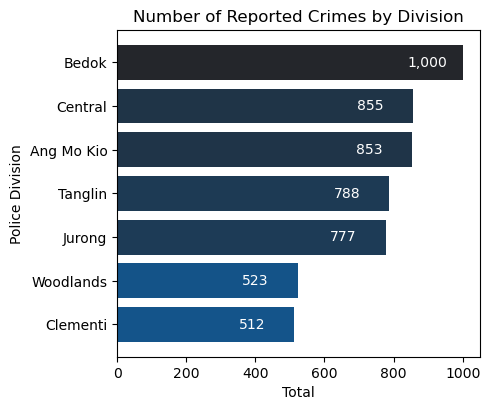

In [226]:
#2021-2023 data -- count for each division
df_division = df[df['DataSeries'].str.contains('Total')].copy()
df_division['DataSeries'] = df_division['DataSeries'].str.replace(' Police Division - Total', '')
df_division = df_division.drop(df_division.iloc[:,4:],axis=1)
df_division.set_index('DataSeries', inplace=True)

df_division['Total'] = df_division.sum(axis=1)
df_division.sort_values(by='Total',ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(5,4)) # To enable size customization
sns.barplot(
    data=df_division,
    y='DataSeries',
    x='Total',
    hue='Total',
    palette='dark:#00569e_r',
    ax=ax
    )

# Creating bar container to set count labels
bar_container = ax.barh(
    df_division.index,
    df_division['Total'],
    align='center',
    edgecolor='none',
    alpha=0 # Make bars transparent, to show seaborn color palette
    )

plt.bar_label(
    bar_container,
    labels=[f'{count:,}' for count in df_division['Total']], # Format + Value (fmt arg not used, likely more complicated)
    label_type='edge',
    padding=-40,
    color='white'
    )

# df_division.plot(
#     kind='barh',
#     y='Total',
#     title='Total Reported Crimes from 2021-2023 by Division'
#     )

plt.style.use('default')
plt.ylabel('Police Division')
plt.legend().set_visible(False)
plt.tight_layout()

plt.savefig('BarChart.png', transparent = True)

plt.title('Number of Reported Crimes by Division')

### Density Map -- Number of reports per square km of land covered by each division

In [227]:
# Shrink function
def shrink_region(feature, buffer_amount):
    '''
    Shrinks geometries of all GeoJSON features by a given amount.
    Args:
        feature (dict): A GeoJSON feature.
        buffer_amount (float): Negative value to shrink the geometry.
    Returns:
        dict: A GeoJSON feature with shrunk geometry.
    '''
    geometry = shape(feature['geometry'])  # Convert to Shapely geometry
    shrunk_geometry = geometry.buffer(buffer_amount)  # Apply buffer
    return {
        'type': 'Feature',
        'geometry': mapping(shrunk_geometry),  # Convert back to GeoJSON format
        'properties': feature['properties'], # Adding back properties
    }

#Chloropleth map TAKE 2
import json

# Opening initial geojson file
geojson_path = 'map.geojson'

with open(geojson_path, 'r') as f:
    geojson_data = json.load(f)

# Shrinking regions minimally to avoid overlap
buffer_amount = -0.000000001
shrunk_features = [
    shrink_region(feature, buffer_amount)
    for feature in geojson_data['features']
    if shrink_region(feature, buffer_amount) is not None
]

# Create new GeoJSON with shrunk regions
shrunk_geojson = {
    'type': 'FeatureCollection',
    'features': shrunk_features,
}

with open('shrunk_geojson.json', 'w') as f:
    json.dump(shrunk_geojson, f)

# Get area covered by each division from shrunk geojson data
extracted_data = []
for feature in shrunk_geojson['features']:
    ID = feature['properties'].get('ID')
    area = feature['properties'].get('Area')
    hover_name = re.sub(r'\d', '', feature['properties'].get('ID'))
    extracted_data.append({'ID': ID, 'Area': area, 'Hover Name': hover_name})

df_area = pd.DataFrame(extracted_data)
df_area['Area'] = pd.to_numeric(df_area['Area'])
df_area = df_area.groupby('Hover Name')['Area'].sum() # Get total area by division (Ignore unique ID)
df_area = pd.DataFrame(df_area).reset_index()

# Create dataframe for plotting
# Columns: ID, Hover name, Total Reports, Density (color value)

df_divCount = df_division.drop(['2023', '2022', '2021'], axis=1).copy() # Getting only total count
df_divCount = df_divCount.sort_index().reset_index()

# Merging area and total count to calculate density
df_density = pd.merge(df_divCount, df_area, left_index=True, right_index=True)
df_density.rename(columns={'Total': 'Total Reports'}, inplace=True)
df_density['Density'] = (df_density['Total Reports'] / df_density['Area']).round(2)
df_density = df_density.drop(['DataSeries', 'Area'], axis=1)

# Match density value to all unique region IDs by merging
df_unique = pd.DataFrame(extracted_data)
df_choropleth = pd.merge(df_unique, df_density, on='Hover Name')

print(df_choropleth) # Final dataframe to plot

# Plot choropleth
choropleth = px.choropleth(
    data_frame=df_choropleth,
    geojson=shrunk_geojson,
    locations='ID',
    featureidkey='properties.ID',
    color='Density',
    hover_name='Hover Name',
    hover_data={'ID': False, 'Total Reports': True, 'Density': True, 'Area': False},
    color_continuous_scale='blues',
    range_color=(0,15), # Limiting color range to increase contrast between each region
    title='Crime Density by Region'
)

choropleth.update_layout(
    # Customizing the color bar at the side
    coloraxis_colorbar=dict(
        tickvals=[0, 5, 10, 15], # Define specific tick positions
        ticktext=['0', '5', '10', '40'], # Custom tick labels
        title='Density (Reports per km²)'
        )
)

choropleth.update_geos(
    fitbounds='locations', # Zoom to GeoJSON regions
    visible=False # Hide base geography
)

choropleth.show()


           ID    Area  Hover Name  Total Reports  Density
0   Clementi1   63.59    Clementi            512     5.39
1      Jurong  140.02      Jurong            777     5.55
2   Clementi2   31.37    Clementi            512     5.39
3  Woodlands1  138.60   Woodlands            523     3.76
4     Central   19.85     Central            855    43.07
5       Bedok  133.89       Bedok           1000     7.47
6  Woodlands2    0.38   Woodlands            523     3.76
7     Tanglin   60.22     Tanglin            788    13.09
8  Ang Mo Kio   88.37  Ang Mo Kio            853     9.65
